In [1]:
!pip install chardet silence_tensorflow
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
!pip install transformers shap lime

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(transformers.__version__)

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4465 sha256=582e376a9884c74c308dcbae086f9306e393213e8a8105cf00a89fc07fb23089
  Stored in directory: /root/.cache/pip/wheels/7d/2c/24/e130d6102c0df56631b9db7479d9a6a53c5d97fb06b5f61b98
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=2a9505e32d364cdc46f63d4cf762b28857aca6c59d4b66c4009f415aee495914
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built silence_tensorflow support_developer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a74b7427377090

In [2]:
train_path = "/content/HealthCare Data.csv"
test_path = "/content/Test_data.csv"

In [3]:

import chardet
train_file = open(train_path, 'rb')
test_file = open(test_path, 'rb')
train_encod = chardet.detect(train_file.read())
test_encod = chardet.detect(test_file.read())

In [4]:
df_train = pd.read_csv(train_path, encoding=train_encod["encoding"])
df_test = pd.read_csv(test_path, encoding=test_encod["encoding"])

In [5]:
df_train

,Patient_comment,Patient_Category
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound
...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache
6657,I have a split on my thumb that will not heal.,Open wound
6658,I feel a lot of pain in the joints.,Joint pain
6659,The area around my heart doesn't feel good.,Heart hurts


In [6]:
df_train.isna().sum()

Patient_comment     0
Patient_Category    0
dtype: int64

<Axes: xlabel='Patient_Category'>

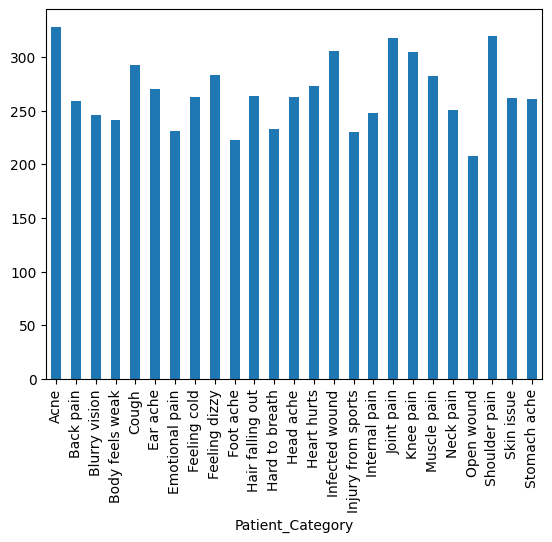

In [7]:
df_train.groupby('Patient_Category').Patient_comment.count().plot.bar(ylim = 0)

<Axes: xlabel='Patient_Category'>

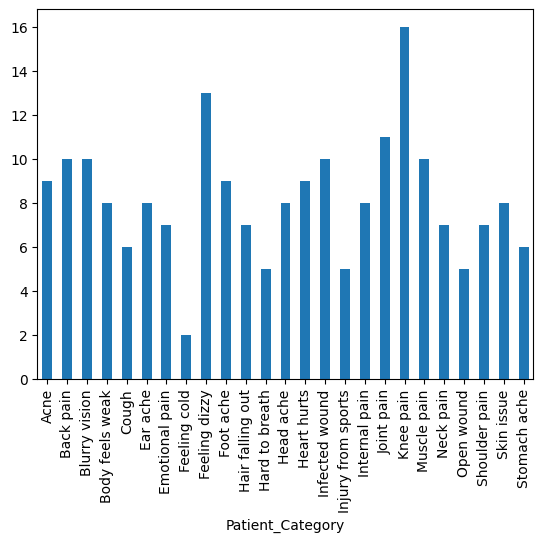

In [8]:
df_test.groupby('Patient_Category').Patient_comment.count().plot.bar(ylim = 0)

In [9]:
doctor_types = {
    'Emotional pain':'Psychiatrist',
    'Hair falling out':'Dermatologist',
    'Heart hurts':'Cardiologist',
    'Infected wound':'Surgeon',
    'Foot ache':'Rheumatologist',
    'Shoulder pain':'Rheumatologist/Gastro-enterologist',
    'Injury from sports':'Rheumatologist',
    'Skin issue':'Dermatologist',
    'Stomach ache':'Gastro-enterologist',
    'Knee pain':'Orthopedist',
    'Joint pain':'Orthopedist',
    'Hard to breath':'Respirologist',
    'Head ache':'Neurologist/Gastro-enterologist',
    'Body feels weak':'General-Physicians',
    'Feeling dizzy':'General-Physicians',
    'Back pain':'Orthopedist',
    'Open wound':'Surgeon',
    'Internal pain':'Gastro-enterologist',
    'Blurry vision':'Ophthalmologist',
    'Acne':'Dermatologist',
    'Muscle pain':'Rheumatologist' ,
    'Neck pain':'Rheumatologist/Orthopedist',
    'Cough':'ENT Specialist',
    'Ear ache':'ENT Specialist',
    'Feeling cold':'ENT Specialist'
}

In [10]:
df_train['specialist_type'] = df_train['Patient_Category'].replace(doctor_types, inplace=False)
df_test['specialist_type'] = df_test['Patient_Category'].replace(doctor_types, inplace=False)

In [11]:
df_train

,Patient_comment,Patient_Category,specialist_type
0,When I remember her I feel down,Emotional pain,Psychiatrist
1,When I carry heavy things I feel like breaking...,Hair falling out,Dermatologist
2,there is too much pain when i move my arm,Heart hurts,Cardiologist
3,My son had his lip pierced and it is swollen a...,Infected wound,Surgeon
4,My muscles in my lower back are aching,Infected wound,Surgeon
...,...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache,Gastro-enterologist
6657,I have a split on my thumb that will not heal.,Open wound,Surgeon
6658,I feel a lot of pain in the joints.,Joint pain,Orthopedist
6659,The area around my heart doesn't feel good.,Heart hurts,Cardiologist


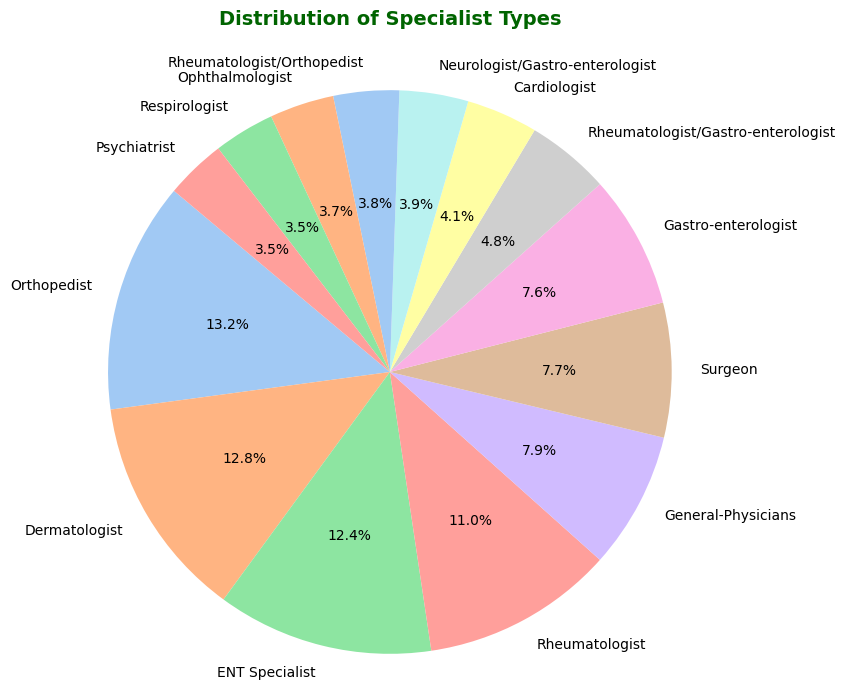

In [12]:
# Calculate the frequency of each cloth class
class_counts = df_train['specialist_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Specialist Types', fontsize = 14, fontweight = 'bold', color = 'darkgreen', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.savefig('Distribution of Specialists.png')
plt.show()

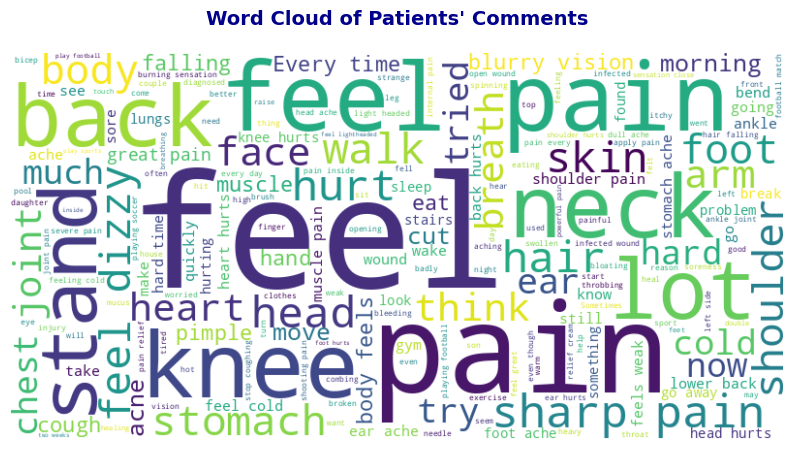

In [13]:
# Convert 'Review' column to string type
#df['Review'] = df['Patient_comment'].astype(str)

# Word Cloud of Reviews
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_train['Patient_comment']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Patients\' Comments', fontsize = 14, fontweight = 'bold', color = 'darkblue', y=1.05)
plt.axis('off')
plt.savefig('Word Cloud.png')
plt.show()

In [14]:
df_train['text'] = df_train['Patient_comment']
df_train['target'] = df_train['specialist_type']
df_test['text'] = df_test['Patient_comment']
df_test['target'] = df_test['specialist_type']

In [15]:
train = df_train.drop(['Patient_comment','specialist_type','Patient_Category'], axis=1)
test = df_test.drop(['Patient_comment','specialist_type','Patient_Category'], axis=1)

In [16]:
# Helper Function to get the running average
def get_weighted(series: pd.Series, beta=0.9):
    weighted = pd.Series(dtype=float)
    weighted[series.index[0]] = 0
    for i in range(1, len(series)):
        current = series.iloc[i]
        previous = weighted.iloc[i-1]
        date = series.index[i]
        weighted[date] = beta*previous + (1-beta)*current
    return weighted

# Get a two-line title for our plots
def get_multi_line_title(title:str, subtitle:str):
    return f"{title}<br><sub>{subtitle}</sub><br>"

In [17]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)

    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0)

    if len(tchr) > 1:
        return tchr[0:2]

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

In [ ]:
# Import Visualization Libraries
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
!pip install scattertext
import scattertext as st
from IPython.display import IFrame
from wordcloud import WordCloud, ImageColorGenerator

In [19]:
df_copy = train.copy()

title = get_multi_line_title("Sentence Length Distribution", "Distribution of number of characters per text, by target")
data = df_copy[df_copy['text'].apply(len) != 0]
top_devices = data.groupby('target')['text'].count().sort_values(ascending=False)[:5].index.tolist()
data = data[data['target'].apply(lambda x: x in top_devices)]
data['sentence_length'] = data.text.apply(len)
fig = px.histogram(data, x="sentence_length", color="target", opacity=0.75)
fig.update_layout(hovermode='x', title=title)
fig.show()

In [26]:
train

,text,target
0,When I remember her I feel down,Psychiatrist
1,When I carry heavy things I feel like breaking...,Dermatologist
2,there is too much pain when i move my arm,Cardiologist
3,My son had his lip pierced and it is swollen a...,Surgeon
4,My muscles in my lower back are aching,Surgeon
...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Gastro-enterologist
6657,I have a split on my thumb that will not heal,Surgeon
6658,I feel a lot of pain in the joints,Orthopedist
6659,The area around my heart doesnt feel good,Cardiologist


In [ ]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import NMF
from sklearn.base import clone

from scipy import interp

import nltk
nltk.download('all', halt_on_error=False)
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim

from collections import Counter

from IPython.display import SVG

#from skater.core.local_interpretation.lime.lime_text import LimeTextExplainer
from lime.lime_text import LimeTextExplainer

In [25]:
# Insight 4: Most Frequent Words in Patient Comments
comments_text = " ".join(comment for comment in train['text'])
words_in_comments = comments_text.split()
word_counts = Counter(words_in_comments)
most_common_words = word_counts.most_common(10)
print("The most frequent words in patient comments are:")
for word, count in most_common_words:
    print(f"- {word}: {count} times")

The most frequent words in patient comments are:
- I: 5920 times
- my: 3472 times
- a: 2098 times
- in: 1944 times
- have: 1606 times
- pain: 1586 times
- and: 1528 times
- feel: 1527 times
- the: 1306 times
- is: 1219 times


In [28]:
# Insight 1: Most Common Patient Categories
common_patient_categories = df_train['Patient_Category'].value_counts().idxmax()
print(f"The most common patient category is: {common_patient_categories}")

# Insight 2: Most Common Target Specialist
common_target_specialist = df_train['target'].value_counts().idxmax()
print(f"The most common target specialist is: {common_target_specialist}")

# Insight 3: Average Length of Patient Comments
avg_comment_length = df_train['Patient_comment'].apply(lambda x: len(x.split())).mean()
print(f"The average length of patient comments is: {avg_comment_length:.2f} words")

The most common patient category is: Acne
The most common target specialist is: Orthopedist
The average length of patient comments is: 10.54 words


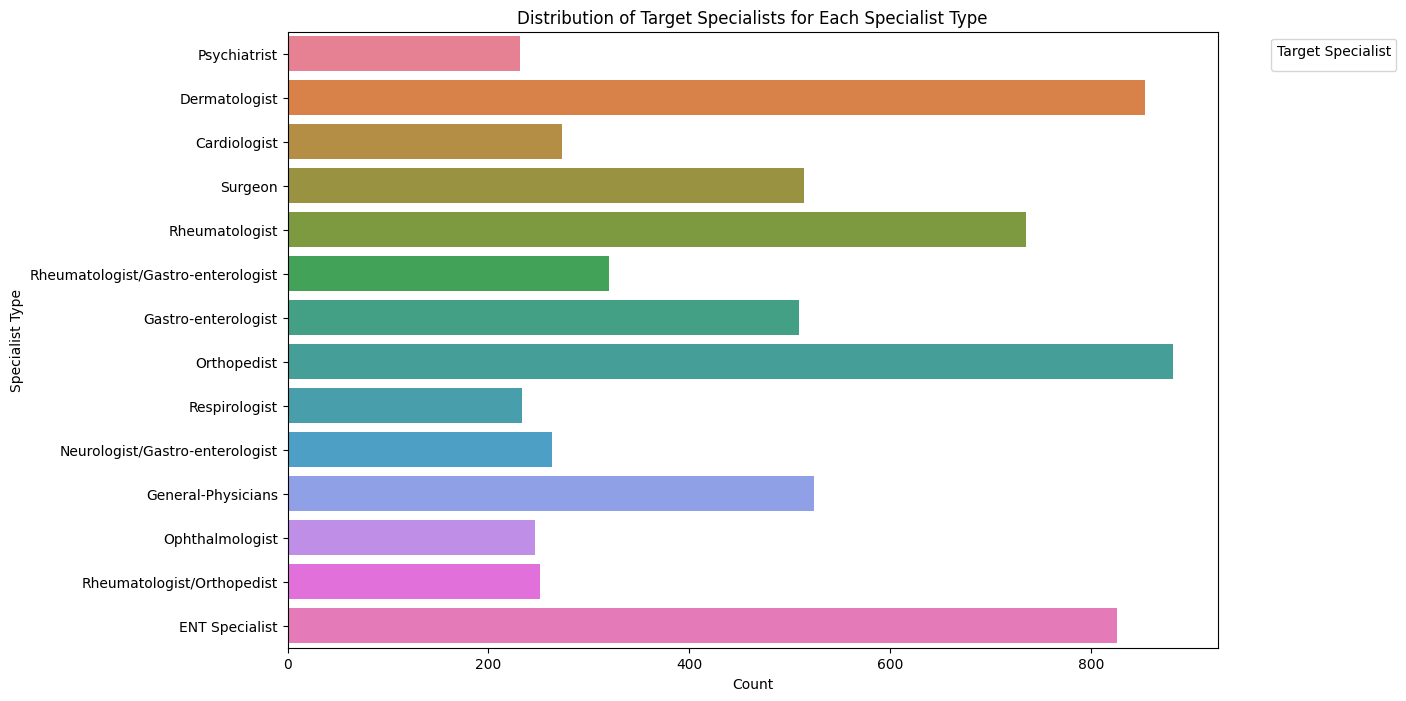

Distribution of Patient Categories for Each Specialist Type:
specialist_type                     Patient_Category  
Cardiologist                        Heart hurts           273
Dermatologist                       Acne                  328
                                    Hair falling out      264
                                    Skin issue            262
ENT Specialist                      Cough                 293
                                    Ear ache              270
                                    Feeling cold          263
Gastro-enterologist                 Stomach ache          261
                                    Internal pain         248
General-Physicians                  Feeling dizzy         283
                                    Body feels weak       241
Neurologist/Gastro-enterologist     Head ache             263
Ophthalmologist                     Blurry vision         246
Orthopedist                         Joint pain            318
                

In [33]:
# Visualization 7: Distribution of Target Specialists for Each Specialist Type
plt.figure(figsize=(12, 8))
sns.countplot(y='specialist_type', hue='target', data=df)
plt.title('Distribution of Target Specialists for Each Specialist Type')
plt.xlabel('Count')
plt.ylabel('Specialist Type')
plt.legend(title='Target Specialist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Insight 5: Distribution of Patient Categories for Each Specialist Type
patient_categories_specialist = df.groupby('specialist_type')['Patient_Category'].value_counts()
print("Distribution of Patient Categories for Each Specialist Type:")
print(patient_categories_specialist)

# Insight 6: Distribution of Target Specialists for Each Specialist Type
target_specialists_specialist = df.groupby('specialist_type')['target'].value_counts()
print("\nDistribution of Target Specialists for Each Specialist Type:")
print(target_specialists_specialist)


## Personalized Treatment and Telemedicine Integration

In [36]:
def recommend_treatment(specialist_type, patient_category):
    # Simulated personalized treatment recommendation logic based on specialist type and patient category
    if specialist_type == 'Cardiologist':
        if patient_category == 'Heart hurts':
            return "Immediate medical attention is required. Please seek emergency care."
        else:
            return "Please consult with a cardiologist for personalized treatment advice."
    elif specialist_type == 'Dermatologist':
        if patient_category in ['Acne', 'Hair falling out', 'Skin issue']:
            return "Dermatological treatment options such as topical creams, medications, or lifestyle changes may be recommended."
        else:
            return "Please consult with a dermatologist for personalized treatment advice."
    elif specialist_type == 'ENT Specialist':
        if patient_category == 'Cough':
            return "Stay hydrated, get plenty of rest, and consider over-the-counter cough medications."
        elif patient_category == 'Ear ache':
            return "Avoid inserting anything into the ear and consult an ENT specialist for proper examination and treatment."
        elif patient_category == 'Feeling cold':
            return "Rest, stay warm, and drink plenty of fluids. Seek medical attention if symptoms worsen."
        else:
            return "Please consult with an ENT specialist for personalized treatment advice."
    elif specialist_type == 'Gastro-enterologist':
        if patient_category == 'Stomach ache':
            return "Avoid spicy or fatty foods, and consider over-the-counter antacids for temporary relief."
        elif patient_category == 'Internal pain':
            return "It's important to get a proper diagnosis. Please consult with a gastroenterologist for further evaluation."
        else:
            return "Please consult with a gastroenterologist for personalized treatment advice."
    elif specialist_type == 'General-Physicians':
        if patient_category == 'Feeling dizzy':
            return "Ensure you are well-hydrated and rested. If symptoms persist, consult with a general physician for evaluation."
        elif patient_category == 'Body feels weak':
            return "Get plenty of rest, eat a balanced diet, and consider consulting with a general physician for further evaluation."
        else:
            return "Please consult with a general physician for personalized treatment advice."
    elif specialist_type == 'Neurologist/Gastro-enterologist':
        if patient_category == 'Head ache':
            return "Ensure you are well-hydrated and rested. If headaches persist, consult with a neurologist for evaluation."
        else:
            return "Please consult with a neurologist or gastroenterologist for personalized treatment advice."
    elif specialist_type == 'Ophthalmologist':
        if patient_category == 'Blurry vision':
            return "Ensure you are well-rested and take regular breaks from screens. If vision problems persist, consult with an ophthalmologist for evaluation."
        else:
            return "Please consult with an ophthalmologist for personalized treatment advice."
    elif specialist_type == 'Orthopedist':
        if patient_category in ['Joint pain', 'Knee pain', 'Back pain']:
            return "Rest, gentle stretching, and over-the-counter pain relievers may provide relief. If symptoms persist, consult with an orthopedist for evaluation."
        else:
            return "Please consult with an orthopedist for personalized treatment advice."
    elif specialist_type == 'Psychiatrist':
        if patient_category == 'Emotional pain':
            return "Seek support from friends and family, and consider speaking with a therapist or psychiatrist for evaluation and support."
        else:
            return "Please consult with a psychiatrist for personalized treatment advice."
    elif specialist_type == 'Respirologist':
        if patient_category == 'Hard to breath':
            return "If experiencing difficulty breathing, seek immediate medical attention. Consult with a respirologist for evaluation."
        else:
            return "Please consult with a respirologist for personalized treatment advice."
    elif specialist_type == 'Rheumatologist':
        if patient_category in ['Muscle pain', 'Injury from sports', 'Foot ache']:
            return "Rest, gentle exercise, and over-the-counter pain relievers may provide relief. If symptoms persist, consult with a rheumatologist for evaluation."
        else:
            return "Please consult with a rheumatologist for personalized treatment advice."
    elif specialist_type == 'Rheumatologist/Gastro-enterologist':
        if patient_category == 'Shoulder pain':
            return "Rest, gentle stretching, and over-the-counter pain relievers may provide relief. If symptoms persist, consult with a rheumatologist or gastroenterologist for evaluation."
        else:
            return "Please consult with a rheumatologist or gastroenterologist for personalized treatment advice."
    elif specialist_type == 'Rheumatologist/Orthopedist':
        if patient_category == 'Neck pain':
            return "Rest, gentle stretching, and over-the-counter pain relievers may provide relief. If symptoms persist, consult with a rheumatologist or orthopedist for evaluation."
        else:
            return "Please consult with a rheumatologist or orthopedist for personalized treatment advice."
    elif specialist_type == 'Surgeon':
        if patient_category in ['Infected wound', 'Open wound']:
            return "Keep the wound clean and dry. If signs of infection develop, seek immediate medical attention. Consult with a surgeon for evaluation."
        else:
            return "Please consult with a surgeon for personalized treatment advice."
    else:
        return "Please consult with a healthcare professional for personalized treatment advice."


def schedule_telemedicine_appointment(specialist_type, telemedicine_platform, appointment_date):
    # Placeholder for actual integration with telemedicine platform
    print(f"Your telemedicine appointment with a {specialist_type} has been scheduled on {appointment_date} via {telemedicine_platform}.")
    print("An email confirmation with the appointment details has been sent to your registered email address.")

def main():
    print("Welcome to the Personalized Medicine System!")
    print("Please provide the following information:")
    specialist_type = input("Enter your specialist type (e.g., Cardiologist, Dermatologist, ENT Specialist): ")
    patient_category = input("Enter your patient category (e.g., Heart hurts, Acne, Cough): ")

    # Call the recommend_treatment function to get the treatment recommendation
    treatment_recommendation = recommend_treatment(specialist_type, patient_category)
    print("\nRecommended Treatment:")
    print(treatment_recommendation)

    # Offer appointment scheduling option
    schedule_appointment = input("Would you like to schedule a telemedicine appointment with a specialist? (yes/no): ")
    if schedule_appointment.lower() == 'yes':
        # Prompt user to choose a telemedicine platform
        telemedicine_platform = input("Please choose your preferred telemedicine platform (e.g., Zoom, Doxy.me): ")
        # Simulate appointment scheduling process
        appointment_date = input("Please enter your preferred appointment date and time (e.g., YYYY-MM-DD HH:MM): ")
        schedule_telemedicine_appointment(specialist_type, telemedicine_platform, appointment_date)

if __name__ == "__main__":
    main()

Welcome to the Personalized Medicine System!
Please provide the following information:
Enter your specialist type (e.g., Cardiologist, Dermatologist, ENT Specialist): ENT Specialist
Enter your patient category (e.g., Heart hurts, Acne, Cough): Acne

Recommended Treatment:
Please consult with an ENT specialist for personalized treatment advice.
Would you like to schedule a telemedicine appointment with a specialist? (yes/no): yes
Please choose your preferred telemedicine platform (e.g., Zoom, Doxy.me): Zoom
Please enter your preferred appointment date and time (e.g., YYYY-MM-DD HH:MM): 2024-05-01
Your telemedicine appointment with a ENT Specialist has been scheduled on 2024-05-01 via Zoom.
An email confirmation with the appointment details has been sent to your registered email address.


In [43]:
import gensim
from gensim import corpora
from pprint import pprint
from gensim.models import CoherenceModel
import numpy as np

# Extract patient comments
documents = train['text']

# Tokenize documents
tokenized_documents = [doc.lower().split() for doc in documents]

# Create dictionary mapping of words to unique IDs
dictionary = corpora.Dictionary(tokenized_documents)

# Create bag of words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Function to calculate coherence score
def calculate_coherence_score(corpus, dictionary, texts, num_topics, passes):
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Grid search for optimal parameters
grid = {}
min_topics = 2
max_topics = 10
step_size = 1
passes_range = range(1, 10)

for num_topics in range(min_topics, max_topics, step_size):
    for passes in passes_range:
        coherence_score = calculate_coherence_score(corpus, dictionary, tokenized_documents, num_topics, passes)
        grid[(num_topics, passes)] = coherence_score

# Select optimal parameters with highest coherence score
optimal_params = max(grid, key=grid.get)
optimal_num_topics, optimal_passes = optimal_params

print(f"Optimal number of topics: {optimal_num_topics}")
print(f"Optimal number of passes: {optimal_passes}")
print(f"Coherence score: {grid[optimal_params]}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Optimal number of topics: 8
Optimal number of passes: 2
Coherence score: 0.29119682246410317


In [ ]:
!pip install pyLDAvis

In [44]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Create pyLDAvis visualization
lda_model = gensim.models.LdaModel(corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=optimal_passes)
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

